In [1]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, cv2, dlib, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import nn, resnet
#from cfgs.fedargs import *

/home/harsh_1921cs01/anaconda3/envs/inf/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Device settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

<h1>Smile: LeNet</h1>

In [3]:
model = nn.LeNet5()
model.load_state_dict(torch.load("../../out/models/celeba(smile)_weights.pth"))
model.eval()

LeNet5(
  (convolutional_layer): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=1250, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [4]:
df = pd.read_csv("../../data/celeba/list_attr_celeba.csv")
df = df[['image_id', 'Smiling']]
smiling = df[df['Smiling'] == 1][:1000]
non_smiling = df[df['Smiling'] == -1][:1000]

df_all = pd.concat([smiling, non_smiling])

a = np.array(df_all)
df = pd.DataFrame(a)
print(df)

               0   1
0     000001.jpg   1
1     000002.jpg   1
2     000009.jpg   1
3     000011.jpg   1
4     000012.jpg   1
...          ...  ..
1995  001924.jpg  -1
1996  001925.jpg  -1
1997  001926.jpg  -1
1998  001928.jpg  -1
1999  001930.jpg  -1

[2000 rows x 2 columns]


In [5]:
train=[]

for i in range(len(a)):
    temp=[]
    temp.append(a[i][0])
    if a[i][1]==-1 :
        temp.append(0)
    else :
        temp.append(a[i][1])
    train.append(temp)
df=pd.DataFrame(train)
print(df)

smiling_size = int(len(smiling))
non_smiling_size = int(len(non_smiling))
df_size = int(len(df))

               0  1
0     000001.jpg  1
1     000002.jpg  1
2     000009.jpg  1
3     000011.jpg  1
4     000012.jpg  1
...          ... ..
1995  001924.jpg  0
1996  001925.jpg  0
1997  001926.jpg  0
1998  001928.jpg  0
1999  001930.jpg  0

[2000 rows x 2 columns]


In [6]:
z_img = torch.tensor([[[0.0 for col in range(32)] for row in range(32)] for dim in range(3)])
z_img.shape
#plt.imshow(z_img.numpy().squeeze())

torch.Size([3, 32, 32])

In [7]:
#!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
#!bunzip2 "shape_predictor_68_face_landmarks.dat.bz2"

In [8]:
detector = dlib.get_frontal_face_detector()
p = "shape_predictor_68_face_landmarks.dat"
# Initialize dlib's shape predictor
predictor = dlib.shape_predictor(p)

In [9]:
i_temp = 0
for i in range(smiling_size):
    tmp_smile = smiling.iloc[i]['image_id']
    image = cv2.imread(f"../../data/celeba/img_align_celeba/{tmp_smile}")
    if image is None:
        print(f"No such video: {tmp_smile}")

    
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(image)
    
    for face in faces:
        if (face.tl_corner().x) > 0:
            i_temp = i_temp +1
    
            landmarks = predictor(image, face)
            left_x = landmarks.part(48).x
            left_y = landmarks.part(50).y
            
           
            right_x = landmarks.part(54).x
            right_y = landmarks.part(56).y
            
            w = np.abs(right_x - left_x)
            h = np.abs(right_y - left_y)
            
            padding_w = np.round(w * 0.4)
            padding_h = np.round(h * 0.9)
            
            left_x  -= padding_w
            right_x += padding_w
            left_y  -= padding_h
            right_y += padding_h
            
            cropped_lip = image[int(left_y):int(right_y), int(left_x):int(right_x)]
            if len(cropped_lip)>0:
                cv2.imwrite(f"../../data/celeba/smile/{tmp_smile}", cropped_lip)
                cv2.imwrite(f"../../data/celeba/all_images/{tmp_smile}", cropped_lip)

In [10]:
i_temp = 0
for i in range(non_smiling_size):
    tmp_smile = non_smiling.iloc[i]['image_id']
    image = cv2.imread(f"../../data/celeba/img_align_celeba/{tmp_smile}")
    if image is None:
        print(f"No such video: {tmp_smile}")

    
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(image)
    
    for face in faces:
        if (face.tl_corner().x) > 0:
            i_temp = i_temp +1
    
            landmarks = predictor(image, face)
            left_x = landmarks.part(48).x
            left_y = landmarks.part(50).y
            
           
            right_x = landmarks.part(54).x
            right_y = landmarks.part(56).y
            
            w = np.abs(right_x - left_x)
            h = np.abs(right_y - left_y)
            
            padding_w = np.round(w * 0.4)        
            padding_h = np.round(h * 0.7)
            
            left_x  -= padding_w
            right_x += padding_w
            left_y  -= padding_h
            right_y += padding_h
            
            cropped_lip = image[int(left_y):int(right_y), int(left_x):int(right_x)]
            if len(cropped_lip)>0:
                cv2.imwrite(f"../../data/celeba/non_smile/{tmp_smile}", cropped_lip)
                cv2.imwrite(f"../../data/celeba/all_images/{tmp_smile}", cropped_lip)

In [11]:
img_list1 = os.listdir("../../data/celeba/smile")

data = {'img_id': [], 'smiles': []}
for j in range(len(img_list1)):
    data['img_id'].append(img_list1[j])
    data['smiles'].append(1)


df_smile = pd.DataFrame(data)
#a = pd.DataFrame(df_smile)

img_list2 = os.listdir("../../data/celeba/non_smile")

data = {'img_id': [], 'smiles': []}
for j in range(len(img_list2)):
    data['img_id'].append(img_list2[j])
    data['smiles'].append(0)


df_non_smile = pd.DataFrame(data)
#b = pd.DataFrame(df_non_smile)

a = pd.concat([df_smile, df_non_smile])

df_np = np.array(a)
df = pd.DataFrame(df_np)
print(df)

               0  1
0     001964.jpg  1
1     000270.jpg  1
2     001710.jpg  1
3     001867.jpg  1
4     001766.jpg  1
...          ... ..
1953  001638.jpg  0
1954  000987.jpg  0
1955  000607.jpg  0
1956  001587.jpg  0
1957  001132.jpg  0

[1958 rows x 2 columns]


In [12]:
min_ = np.min([len(df[df[1] == 0]), len(df[df[1] == 1])])

smiling = df[df[1] == 1].iloc[:min_]
non_smiling = df[df[1] == 0].iloc[:min_]

train = pd.concat([smiling,non_smiling])
train.reset_index(drop=True, inplace=True)


indices = np.arange(0, len (train))
np.random.seed(42)
np.random.shuffle(indices)

train_size = int(0.8*len(indices))
test_size = int(0.1*len(indices))
val_size = int(0.1*len(indices))


train_indices = indices[:train_size]
indices = indices[train_size:]

test_indices = indices[:test_size]
indices = indices[test_size:]

val_indices = indices[:val_size]
indices = indices[val_size:]

train_database = train.iloc[train_indices]
test_database = train.iloc[test_indices]
val_database = train.iloc[val_indices]

In [13]:
train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])
 
test_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
])
 
val_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
])

In [14]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, index):
        item = self.data.iloc[index]
 
        path = self.root + "/" + item[0]
        #image = Image.open(path).convert('L')
    
        image = Image.open(path)
        
        label = item[1]
 
        if self.transform is not None:
            image = self.transform(image)
 
        return image, label

In [15]:
IMG_PATH ="../../data/celeba/all_images"
 
train_data  = Dataset(train_database, IMG_PATH, train_transform)
test_data  = Dataset(test_database, IMG_PATH, test_transform)
val_data  = Dataset(val_database, IMG_PATH, val_transform)
 
train_data_size = len(train_data)
test_data_size = len(test_data)
val_data_size = len(val_data)
print(train_data_size)
print(test_data_size)
print(val_data_size)

1542
192
192


In [16]:
batch_size = 64
trainLoader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
valLoader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [17]:
testiter = iter(testLoader)
images, labels = testiter.next()

In [18]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    pred = model(images)

images_np = [i.cpu() for i in images]
class_names = ['no_smile', 'smile']

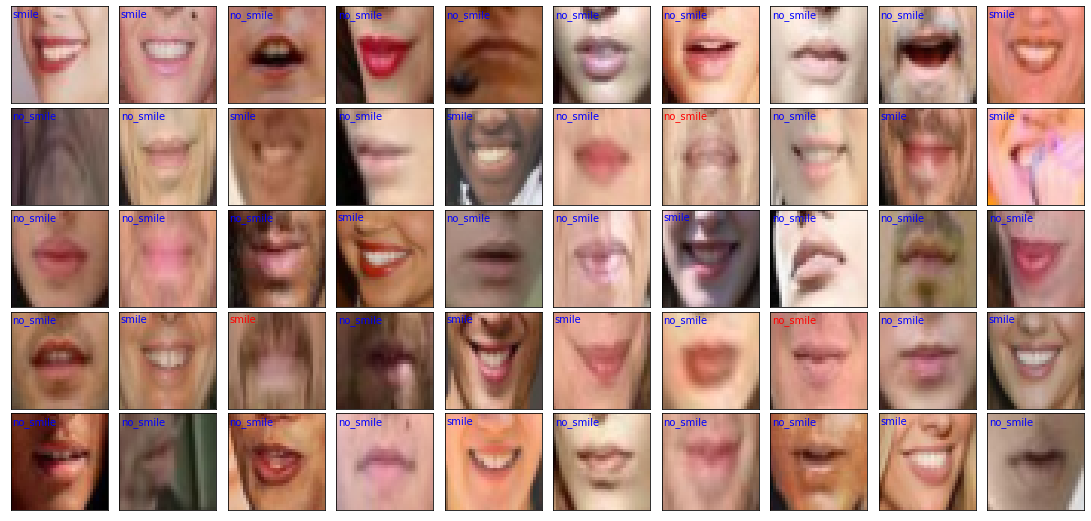

In [19]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
 
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')
 
    if labels[i] == torch.max(pred[i], 0)[1]:
        ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='blue')
    else:
        ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')

<h1>SHAP Explain</h1>

In [20]:
def shap_plot(explain, img, size):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(2):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(size).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    return shap_values

In [21]:
batch = next(iter(testLoader))
images, labels = batch
baseline = images
    
explain = shap.DeepExplainer(model, baseline)

In [22]:
batch = next(iter(testLoader))
images, labels = batch
g_img, label = images[0], labels[0]
#plt.imshow(g_img.numpy().squeeze())
print(label)
g_img.shape

tensor(0)


torch.Size([3, 32, 32])

In [23]:
z_img = torch.tensor([[[0.0 for col in range(32)] for row in range(32)] for dim in range(3)])
#z_img = z_img.reshape(1,28,28)
z_img.shape
#plt.imshow(z_img.numpy().squeeze())

torch.Size([3, 32, 32])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 0.34265723643436985
shap_sum 0.20006653367028093


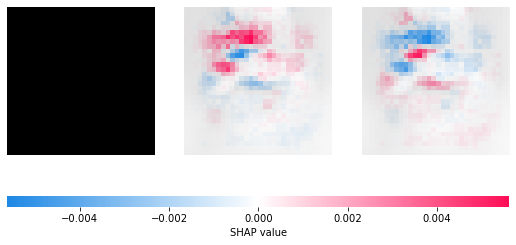

In [24]:
shap_values = shap_plot(explain, g_img, 3072)

shap_sum 3.2838676251661756
shap_sum 3.2509411668683583


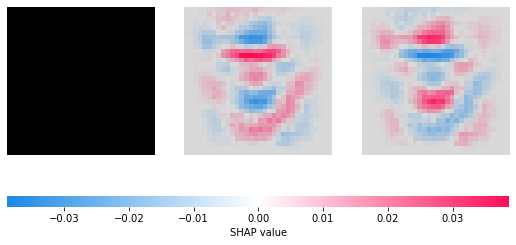

In [25]:
smile_shap_values = shap_plot(explain, z_img, 3072)

<h1>Gender: ResNet</h1>

In [26]:
df = pd.read_csv('../../data/celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Smiling'])

df1 = df[df['Smiling'] == 1]

df1 = df1[['Male']]
print(len(df), len(df1))

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.tail()

202599 97669


,Male
202592.jpg,0
202593.jpg,0
202596.jpg,1
202597.jpg,1
202598.jpg,0


In [27]:
df2 = pd.read_csv('../../data/celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [28]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [29]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [30]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


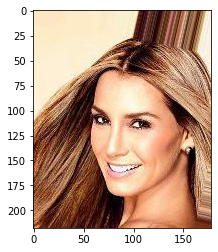

In [31]:
img = Image.open('../../data/celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [32]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [33]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
BATCH_SIZE = 256

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='../../data/celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [34]:
r_model = resnet.ResNet18(2)
r_model.load_state_dict(torch.load("../../out/models/celeba(mf)_weights.pth", map_location ='cpu'))
r_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h1>SHAP Explain</h1>

In [35]:
r_batch = next(iter(test_loader))
r_images, r_labels = r_batch
r_baseline = r_images
    
r_explain = shap.DeepExplainer(r_model, r_baseline)

In [36]:
r_img = torch.tensor([[[0.0 for col in range(128)] for row in range(128)] for dim in range(3)])
#z_img = z_img.reshape(1,28,28)
r_img.shape
#plt.imshow(z_img.numpy().squeeze())

torch.Size([3, 128, 128])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap_sum 2551.8634239136077
shap_sum 2835.8115017253494


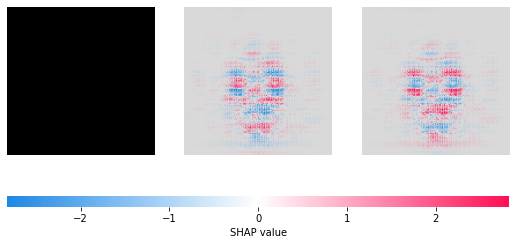

In [37]:
r_shap_values = shap_plot(r_explain, r_img, 49152)

<h1>PIA</h1>

In [38]:
rt_shap_values = torch.tensor(r_shap_values)
rt_shap_values.shape

torch.Size([2, 1, 3, 128, 128])

In [39]:
st_shap_values = torch.tensor(s_shap_values)
st_shap_values.shape

NameError: name 's_shap_values' is not defined

In [ ]:
m_img = copy.deepcopy(r_img)
for dim in range (3):
    for row in range(32):
        for col in range(32):
            m_img[dim][row][col] = m_img[dim][row][col] + g_img[dim][row][col]
print(m_img.shape)

In [ ]:
m_shap_values = shap_plot(r_explain, m_img, 49152)

<h1>MS_FS</h1>

In [ ]:
ms_fs_model = resnet.ResNet18(2)
ms_fs_model.load_state_dict(torch.load("../../out/models/celeba(ms_fs)_weights_10k.pth", map_location ='cpu'))
ms_fs_model.eval()
ms_fs_explain = shap.DeepExplainer(ms_fs_model, r_baseline)
ms_fs_shap_values = shap_plot(ms_fs_explain, r_img, 49152)

<h1>MNS_FNS</h1>

In [ ]:
mns_fns_model = resnet.ResNet18(2)
mns_fns_model.load_state_dict(torch.load("../../out/models/celeba(mns_fns)_weights_10k.pth", map_location ='cpu'))
mns_fns_model.eval()
mns_fns_explain = shap.DeepExplainer(mns_fns_model, r_baseline)
mns_fns_shap_values = shap_plot(mns_fns_explain, r_img, 49152)

<h1>MS_FNS</h1>

In [ ]:
ms_fns_model = resnet.ResNet18(2)
ms_fns_model.load_state_dict(torch.load("../../out/models/celeba(ms_fns)_weights_10k.pth", map_location ='cpu'))
ms_fns_model.eval()
ms_fns_explain = shap.DeepExplainer(ms_fns_model, r_baseline)
ms_fns_shap_values = shap_plot(ms_fns_explain, r_img, 49152)

<h1>MNS_FS</h1>

In [ ]:
mns_fs_model = resnet.ResNet18(2)
mns_fs_model.load_state_dict(torch.load("../../out/models/celeba(mns_fs)_weights_10k.pth", map_location ='cpu'))
mns_fs_model.eval()
mns_fs_explain = shap.DeepExplainer(mns_fs_model, r_baseline)
mns_fs_shap_values = shap_plot(mns_fs_explain, r_img, 49152)

<h1>Cosine Similarity<h1>

In [ ]:
r_shap_female = torch.tensor(r_shap_values[0]).view(-1)
r_shap_male = torch.tensor(r_shap_values[1]).view(-1)

In [ ]:
ms_fs_female = torch.tensor(ms_fs_shap_values[0]).view(-1) 
ms_fs_male = torch.tensor(ms_fs_shap_values[1]).view(-1)

In [ ]:
mns_fns_female = torch.tensor(mns_fns_shap_values[0]).view(-1) 
mns_fns_male = torch.tensor(mns_fns_shap_values[1]).view(-1) 

In [ ]:
ms_fns_female = torch.tensor(ms_fns_shap_values[0]).view(-1) 
ms_fns_male = torch.tensor(ms_fns_shap_values[1]).view(-1) 

In [ ]:
mns_fs_female = torch.tensor(mns_fs_shap_values[0]).view(-1) 
mns_fs_male = torch.tensor(mns_fs_shap_values[1]).view(-1) 

In [ ]:
print(sim.cosine_similarity(r_shap_female, ms_fs_female))
print(sim.cosine_similarity(r_shap_female, mns_fns_female))
print(sim.cosine_similarity(r_shap_female, ms_fns_female))
print(sim.cosine_similarity(r_shap_female, mns_fs_female))

In [ ]:
print(sim.cosine_similarity(r_shap_male, ms_fs_male))
print(sim.cosine_similarity(r_shap_male, mns_fns_male))
print(sim.cosine_similarity(r_shap_male, ms_fns_male))
print(sim.cosine_similarity(r_shap_male, mns_fs_male))